# Heart segmentation

In [1]:
import os, re
import pickle
import scipy
import json
from collections import OrderedDict
from datetime import datetime
from tqdm import tqdm

from scipy import stats
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
import seaborn as sns
from brokenaxes import brokenaxes

import SimpleITK as sitk
import tifffile

from mousechd.datasets.utils import  get_bbx, get_largest_connectivity
from mousechd.utils.analyzer import set_default_mplstyle, plot_gallery

HOME = os.environ.get('HOME')
DATADIR = os.path.join(HOME, "DATA/INCEPTION_2020-CHD/Mice/DATA/CTs")
MASKDIR = os.path.join(DATADIR, "processed/Imagine/heart-masks")
OUTDIR = os.path.join(HOME, "DATA/INCEPTION_2020-CHD/Mice/OUTPUTS/HeartSeg")
TASK = "Task113_MouseHeartImagine20210807"

In [2]:
%matplotlib inline
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1.5
# SAVEDIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/PAPER/FIGURES/Fig03/Components"
SAVEDIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/PAPER/FIGURES/revision0/components"
os.makedirs(SAVEDIR, exist_ok=True)

## Number of manual segmentation slices

In [97]:
mask_ls = [x for x in os.listdir(MASKDIR) if x.endswith('nii.gz') and not x.startswith('.')]
nslices = 0
for imname in tqdm(mask_ls):
    img = sitk.ReadImage(os.path.join(MASKDIR, imname))
    im = sitk.GetArrayFromImage(img)
    (min_z, max_z), (_, _), (_, _) = get_bbx(im)
    nslices += max_z - min_z + 1
    
print(nslices)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:57<00:00,  1.44s/it]

6261


## Volumes

In [90]:
# Run post process first
!mousechd postprocess_nnUNet \
    -indir $HOME/DATA/INCEPTION_2020-CHD/Mice/OUTPUTS/HeartSeg/Imagine \
        -outdir $HOME/DATA/INCEPTION_2020-CHD/Mice/OUTPUTS/HeartSeg/POSTPROCESSED



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

In [94]:
try:
    volume_df = pd.read_csv(f"{DATADIR}/processed/Imagine/volumes.csv")
except FileNotFoundError:
    volume_df = pd.read_csv(os.path.join(DATADIR, "resampled/Imagine/resampled.csv"))
    volume_df["volume"] = None
    heart_ls = volume_df["heart_name"].values

    for idx, f, spacing in zip(volume_df.index.tolist(),
                               volume_df.heart_name.values,
                               volume_df.resampled_spacing.values):
        spacing = eval(spacing)
        im = tifffile.imread(f"{OUTDIR}/POSTPROCESSED/{f}.tif")
        vol = (im != 0).sum()
        
        volume_df.loc[idx, "volume"] = vol*spacing[0]*spacing[1]*spacing[2]
        
    volume_df[["heart_name", "volume"]].to_csv(f"{DATADIR}/processed/Imagine/volumes.csv", index=False)
    
label_df = pd.read_csv(f"{DATADIR}/resampled/Imagine/metadata_20210203.csv")
volume_df["stage"] = volume_df["heart_name"].map(label_df.set_index("heart_name").to_dict()["Stage"])
volume_df["label"] = volume_df["heart_name"].map(label_df.set_index("heart_name").to_dict()["Normal heart"])

def decode_label(x):
    if x == 1:
        return "Normal"
    else:
        return "CHD"
    
volume_df["label"] = volume_df["label"].map(decode_label)

volume_df["label"].value_counts()

label
Normal    101
CHD        38
Name: count, dtype: int64

### Volumes vs Labels

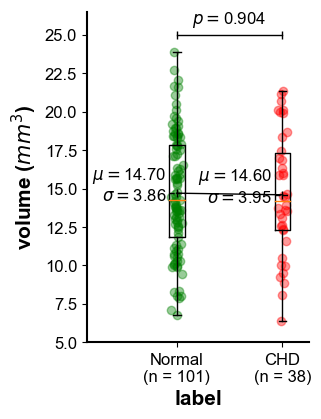

In [95]:
today = datetime.now().strftime('%Y%m%d')

vals, names, xs, labels = [], [], [], []

# stages = ["E18.5","P0"]
stages = ["Normal", "CHD"]

for i, stage in enumerate(stages):
    # vals.append(volume_df[volume_df["stage"]==stage]["volume"].values)
    # labels.append(volume_df[volume_df["stage"]==stage]["label"].values)
    # names.append("{}\n(n = {})".format(stage, len(volume_df[volume_df["stage"]==stage])))
    # xs.append(np.random.normal(i+1, 0.02, volume_df[volume_df["stage"]==stage]["volume"].values.shape[0]))
    vals.append(volume_df[volume_df["label"]==stage]["volume"].values)
    labels.append(volume_df[volume_df["label"]==stage]["label"].values)
    names.append("{}\n(n = {})".format(stage, len(volume_df[volume_df["label"]==stage])))
    xs.append(np.random.normal(i+1, 0.02, volume_df[volume_df["label"]==stage]["volume"].values.shape[0]))
    
# plt.figure(figsize=(3,3.25))
plt.figure(figsize=(3,4))
plt.boxplot(vals, labels=names, 
            meanline=True, showmeans=True,
            meanprops={'color': 'k'}
           )

palette = ["r", "g"]
for x, val, label in zip(xs, vals, labels):
    normal_idx = (label == "Normal")
    ab_idx = (label == "CHD")
    plt.scatter(x[normal_idx], val[normal_idx], alpha=0.4, color="g", label="Normal")
    plt.scatter(x[ab_idx], val[ab_idx], alpha=0.4, color="r", label="CHD")
    
# Mean
plt.text(0.9,vals[0].mean(),
         r'$\mu=$' + '{:.2f}\n'.format(vals[0].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[0])),
         ha="right", va="center",
         fontsize=12
        );

plt.text(1.9,vals[1].mean(),
         r'$\mu=$' + '{:.2f}\n'.format(vals[1].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[1])),
         ha="right", va="center",
         fontsize=12
        );
plt.plot([1,2], [vals[0].mean(), vals[1].mean()], '|-k', linewidth=1)

# test
plt.plot([1,2], [25,25], linewidth=1, c="k", marker="|")

# plt.text(1.5,27,
#         #  "t-test",
#         #  "Wilcoxon signed-rank test",
#          "Mann-Whitney U test",
#          weight="bold",
#          ha="center", va="center",
#          fontsize=12
#         );

plt.text(1.5,26,
         r'$p=$' + '{:.3f} '.format(
            #  stats.ttest_ind(vals[0], vals[1]).pvalue
             stats.mannwhitneyu(vals[0], vals[1]).pvalue
         ),
         ha="center", va="center",
         fontsize=12
        );


plt.ylim(5, 26.5)
plt.xlim(0.15, 2.25)
plt.ylabel("volume ($mm^3$)", fontsize=15, weight='bold')
plt.xlabel("label", fontsize=15, weight='bold')
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
# plt.savefig(os.path.join(SAVEDIR, f'volume_label_{today}.svg'), bbox_inches='tight', dpi=1000)


### Volumes vs Stages (Figure 3f)

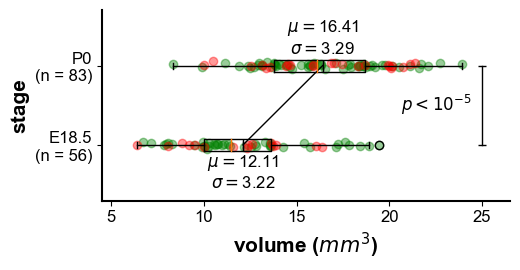

In [96]:
today = datetime.now().strftime('%Y%m%d')

vals, names, xs, labels = [], [], [], []

stages = ["E18.5","P0"]

for i, stage in enumerate(stages):
    vals.append(volume_df[volume_df["stage"]==stage]["volume"].values)
    labels.append(volume_df[volume_df["stage"]==stage]["label"].values)
    names.append("{}\n(n = {})".format(stage, len(volume_df[volume_df["stage"]==stage])))
    xs.append(np.random.normal(i+1, 0.02, volume_df[volume_df["stage"]==stage]["volume"].values.shape[0]))
    
plt.figure(figsize=(5,2.5))
plt.boxplot(vals, labels=names, 
            meanline=True, showmeans=True,
            meanprops={'color': 'k'},
            vert=False
           )

palette = ["r", "g"]
for x, val, label in zip(vals, xs, labels):
    normal_idx = (label == "Normal")
    ab_idx = (label == "CHD")
    plt.scatter(x[normal_idx], val[normal_idx], alpha=0.4, color="g", label="Normal")
    plt.scatter(x[ab_idx], val[ab_idx], alpha=0.4, color="r", label="CHD")
    
# Mean
plt.text(vals[0].mean(), 0.9,
         r'$\mu=$' + '{:.2f}\n'.format(vals[0].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[0])),
         ha="center", va="top",
         fontsize=12
        );

plt.text(vals[1].mean(), 2.6,
         r'$\mu=$' + '{:.2f}\n'.format(vals[1].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[1])),
         ha="center", va="top",
         fontsize=12
        );
plt.plot([vals[0].mean(), vals[1].mean()], [1,2], '|-k', linewidth=1)

# # test
plt.plot([25,25], [1,2], linewidth=1, c="k", marker="_")

# plt.text(20, 1.65,
#         #  "t-test",
#         #  "Wilcoxon signed-rank test",
#          "Mann-Whitney U test",
#          weight="bold",
#          ha="center", va="center",
#          fontsize=12
#         );

# plt.text(20, 1.3,
#          r'$p=$' + '{:.3f} '.format(
#             #  stats.ttest_ind(vals[0], vals[1]).pvalue
#             #  stats.wilcoxon(vals[0], vals[1]).pvalue
#              stats.mannwhitneyu(vals[0], vals[1]).pvalue
#          ) + "\n(n1 = {}, n2 = {})".format(len(vals[0]), len(vals[1])),
#          ha="center", va="center",
#          fontsize=12
#         );
plt.text(22.5, 1.5,
         r'$p<10^{-5}$',
         ha="center", va="center",
         fontsize=12
        );


plt.xlim(4.5,26.5)
plt.ylim(0.3, 2.7)
plt.xlabel("volume ($mm^3$)", fontsize=15, weight='bold')
plt.ylabel("stage", fontsize=15, weight='bold')
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
# plt.savefig(os.path.join(SAVEDIR, f'volume_stage_{today}.svg'), bbox_inches='tight', dpi=1000)

## Metrics

In [51]:
def calc_dsc(pred, gt):
    pred = (pred != 0)
    gt = (gt != 0)
    overlap = (pred & gt)
    return 2*overlap.sum()/(pred.sum() + gt.sum())

def calc_recall(pred, gt):
    pred = (pred != 0)
    gt = (gt != 0)
    
    return (pred & gt).sum()/gt.sum()

def calc_precision(pred, gt):
    pred = (pred != 0)
    gt = (gt != 0)
    
    tp = (pred & gt).sum()
    fp = (pred & (1-gt)).sum()
    
    return tp/(tp+fp)

def calc_accuracy(pred, gt):
    pred = (pred != 0)
    gt = (gt != 0)
    
    tp = (pred & gt).sum()
    tn = ((1 - pred) & (1 - gt)).sum()
    
    return (tp + tn)/(pred.shape[0]*pred.shape[1]*pred.shape[2])


def load_test_result(path, ensemble=True):
    results = {}
    for i in range(5):
        results[f"fold{i}"] = pickle.load(open(os.path.join(path, f"fold{i}", "evaluation.pkl"),"rb"))
    
    if ensemble:
        results["ensemble"] = pickle.load(open(os.path.join(path, "ensemble", "evaluation.pkl"),"rb"))
        
    return results


def get_mean_from_test_result(results):
    mean_results = {}
    metrics_name = ["Dice", "Recall","Precision", "Accuracy"]
    for metric in metrics_name:
        mean_results[metric] = []
        
    for f in results.keys():
        for metric in metrics_name:
            x = 0
            for name in results[f].keys():
                x += results[f][name][metric]
            mean_results[metric].append(x/len(results[f].keys()))
    
    return mean_results

In [113]:
# Calculate segmentation metrics of post_processed ensemble 
nnunet_data = json.load(open(f"{DATADIR}/processed/Imagine/{TASK}.json", "r"))
heartls = [re.sub(r".nii.gz$", "", x.split("/")[-1]) for x in nnunet_data["test"]]
seg_metrics = pd.DataFrame(columns=["heart_name", "dsc", "precision", "recall", "accuracy"])

try:
    seg_metrics = pd.read_csv(f"{OUTDIR}/metrics_postprocessed_ensemble.csv")
except FileNotFoundError:
    for heart in tqdm(heartls):
        mask = sitk.ReadImage(f"{MASKDIR}/{heart}")
        mask = sitk.GetArrayFromImage(mask)
        pred = tifffile.imread(f"{OUTDIR}/POSTPROCESSED/{heart}.tif")
        
        seg_metrics.loc[len(seg_metrics), :] = [re.sub(r".nii.gz$", "", heart),
                                                calc_dsc(pred.copy(), mask.copy()),
                                                calc_precision(pred.copy(), mask.copy()),
                                                calc_recall(pred.copy(), mask.copy()),
                                                calc_accuracy(pred.copy(), mask.copy())]
    
    seg_metrics.to_csv(f"{OUTDIR}/metrics_postprocessed_ensemble.csv", index=False)
        
        
fold_metrics = load_test_result(
    f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/archive/refactor/CTs/HeartSeg/nnUnet/{TASK}"
)

mean_metrics = get_mean_from_test_result(fold_metrics)

# Replace ensemble metrics with post-processed ensemble metrics
mean_metrics["Dice"][5] = seg_metrics["dsc"].mean()
mean_metrics["Recall"][5] = seg_metrics["recall"].mean()
mean_metrics["Precision"][5] = seg_metrics["precision"].mean()
mean_metrics["Accuracy"][5] = seg_metrics["accuracy"].mean()

100%|██████████| 12/12 [01:53<00:00,  9.50s/it]


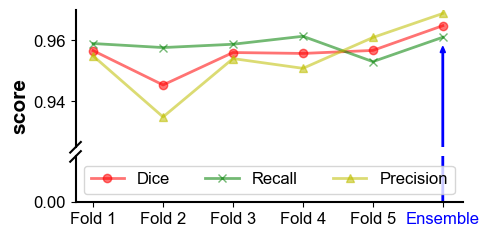

In [99]:
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1.5

markers = ("o", "x", "^")
colors = ('r', 'g', 'y')
metrics_name = ["Dice", "Recall","Precision"]


plt.figure(figsize=(5,2.5))
ax = brokenaxes(ylims=((0,.015), (0.925, 0.97)), hspace=0.1)
for i, metric in enumerate(metrics_name):
    ax.plot(
        mean_metrics[metric],"{}-".format(markers[i]), label=metric, linewidth=2, alpha=0.55,
        color=colors[i]
    )
# plt.xlim(-0.2,5.2)
# # plt.ylim(0.9,1)
# plt.ylim(0.925,0.98)
ax.set_xticks([0,1,2,3,4, 5],["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Ensemble"], 
              fontsize=12
        #    rotation=30,
        #    ha='right'
)

ax.arrow(
    x=5, y=0, dx=0, dy=mean_metrics["Recall"][5]-0.005,
    width=0.02,
    head_width=0.075,
    head_length=0.002,
    color="b"
)

xlabel_colors = ["k"]*5 + ["b"]
for xtick, color in zip(ax.get_xticklabels()[1][1:], xlabel_colors):
    xtick.set_color(color)

# plt.gca().legend().set_title("Metrics")    
# plt.legend(loc="upper left", mode='expand', ncol=3)
# # plt.gca().legend().set_title("Metrics")
# plt.ylabel("score", fontsize=12, weight='bold');
# plt.tight_layout(pad=0, h_pad=0, w_pad=0)
ax.legend(loc='lower left', mode='expand', ncol=3, fontsize=12)
ax.set_ylabel("score", fontsize=15, weight='bold');
today = datetime.now().strftime('%Y%m%d')
plt.savefig(os.path.join(SAVEDIR, f'segment_score_{today}.svg'), bbox_inches='tight', dpi=1000)

In [100]:
mean_metrics

{'Dice': [0.956629078110305,
  0.9453954281503449,
  0.9560092748929981,
  0.9557107738227163,
  0.9566967886747043,
  0.9647920432550197],
 'Recall': [0.9589554391898267,
  0.9576306805623677,
  0.9587183788660151,
  0.9613294800434832,
  0.9530305918310541,
  0.9610101431547763],
 'Precision': [0.9549001472423712,
  0.934930655667951,
  0.9540274339478776,
  0.9508358909374565,
  0.9609285218043104,
  0.9687916798027668],
 'Accuracy': [0.9791354961061355,
  0.9782547055992777,
  0.9790058922684217,
  0.9802752320064344,
  0.9762340657124821,
  0.9989693077901999]}

## Segmetation time

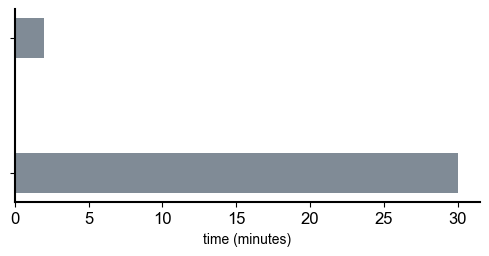

In [101]:
# Horizontal
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

plt.figure(figsize=(6,2.5))
plt.barh(["x","y"], [30,2], height=0.3, color="#808B96")
plt.xlabel("time (minutes)")
plt.gca().axes.yaxis.set_ticklabels([]);

[Text(0, 0, ''), Text(1, 0, '')]

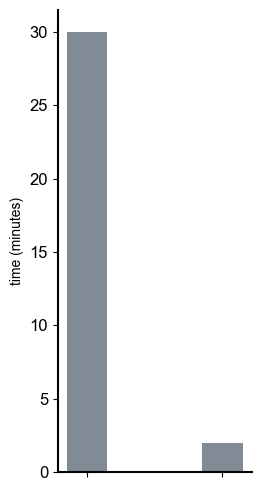

In [102]:
# Vertical
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

plt.figure(figsize=(2.5,6))
plt.bar(["x","y"], [30,2], width=0.3, color="#808B96")
plt.ylabel("time (minutes)")
plt.gca().axes.xaxis.set_ticklabels([])

## Embryologist's evaluation

In [107]:
eval_df = pd.read_csv(f"{OUTDIR}/seg-validation.csv", sep=";")
eval_df['Sample final'] = eval_df['Sample final'].str.strip(" ")

label_df["nnUnet"] = label_df["heart_name"].map(
    eval_df.set_index("Sample final").to_dict()["nnUNet segmentation"]
)
label_df['comment'] = label_df["heart_name"].map(
    eval_df.set_index("Sample final").to_dict()["Comment"]
)

label_df["Label"] = label_df["Normal heart"].map(decode_label)

EVAL_MAPS = {"OK perfect": "perfect",
            "missing tissue": "under",
            "extra tissue segmented": "over"}

label_df["nnUnet"] = label_df["nnUnet"].map(EVAL_MAPS)

FIELDS = ["heart_name", "Stage", "Label", "nnUnet", "comment"]
label_df = label_df[~label_df['nnUnet'].isna()].reset_index(drop=True)
label_df = label_df[~label_df['heart_name'].isin(nnunet_data['training'])].reset_index(drop=True)

label_df1 = label_df.copy()
trainls = [re.sub(r".nii.gz$", "", x["image"].split("/")[-1]) for x in  nnunet_data["training"]]
label_df1 = label_df1[~label_df1["heart_name"].isin(trainls)]
label_df1['nnUnet'] = label_df1['nnUnet'].map({'under': 'imperfect', 'over': 'imperfect', 'perfect': 'perfect'})
test = pd.DataFrame(label_df1['nnUnet'].value_counts()).reset_index()
test.columns = ['Evaluation', 'Number']
test

,Evaluation,Number
0,perfect,96
1,imperfect,15


/tmp/ipykernel_384216/1709852983.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

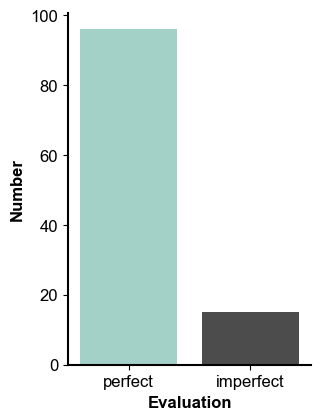

In [104]:
plt.figure(figsize=(3,4))
sns.barplot(
    data=test, x="Evaluation", y="Number", alpha=0.7,
    ci=None, palette=["#73C6B6", "#000000", "#D98880"],
)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.xlabel('Evaluation', fontsize=12, weight='bold')
plt.ylabel('Number', fontsize=12, weight='bold');

/tmp/ipykernel_384216/1631462761.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

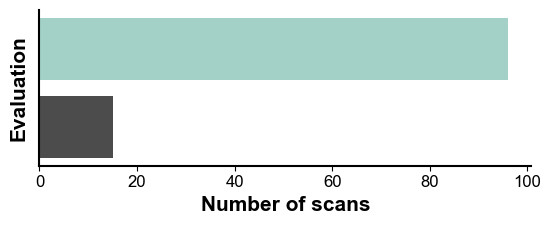

In [105]:
plt.figure(figsize=(6,2))
# plt.figure(figsize=(4,2.5))
sns.barplot(
    data=test, y="Evaluation", x="Number", alpha=0.7,
    ci=None, palette=["#73C6B6", "#000000", "#D98880"],
)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.yticks([])
plt.xlabel('Number of scans', fontsize=15, weight='bold')
plt.ylabel('Evaluation', fontsize=15, weight='bold');
today = datetime.now().strftime('%Y%m%d')
plt.savefig(os.path.join(SAVEDIR, f'evaluation_{today}.svg'), bbox_inches='tight', dpi=1000)

/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

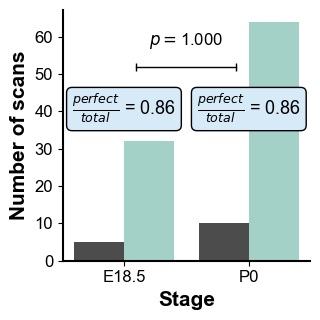

In [61]:
eval_stage = pd.crosstab(label_df1["Stage"], label_df1["nnUnet"]).stack().reset_index()
eval_stage.columns = ["Stage", "nnUnet", "Number"]

plt.figure(figsize=(3,3))
ax = sns.barplot(
    data=eval_stage, x="Stage", y="Number", hue="nnUnet", alpha=0.7,
    errorbar=None, 
    # palette=["#D98880", "#73C6B6", "#000000"]
    palette=["#000000", "#73C6B6"]
)
plt.ylabel("Number of scans", fontsize=15, weight='bold')
plt.xlabel("Stage", fontsize=15, weight='bold')

plt.text(0,45,
         r'$\frac{perfect}{total}$'+ ' = {:.2f}'.format(
             eval_stage[(eval_stage["Stage"]=="E18.5") & (eval_stage["nnUnet"]=="perfect")]["Number"].sum()/
             eval_stage[eval_stage["Stage"]=="E18.5"]["Number"].sum()),
         fontsize=13,
         ha="center", va="top",
         bbox=dict(boxstyle="round,pad=0.3", fc="#D6EAF8"));

plt.text(1,45,
         r'$\frac{perfect}{total}$'+ ' = {:.2f}'.format(
             eval_stage[(eval_stage["Stage"]=="P0") & (eval_stage["nnUnet"]=="perfect")]["Number"].sum()/
             eval_stage[eval_stage["Stage"]=="P0"]["Number"].sum()),
         fontsize=13,
         ha="center", va="top",
         bbox=dict(boxstyle="round,pad=0.3", fc="#D6EAF8"));

plt.plot([0.1,0.9], [52, 52], linewidth=1, c="k", marker="|")

tb = eval_stage = pd.crosstab(label_df1["Stage"], label_df1["nnUnet"])
plt.text(0.5, 59,
         r'$p=$' + '{:.3f} '.format(
            #  stats.ttest_ind(vals[0], vals[1]).pvalue
             chi2_contingency(tb)[1]
         ),
         ha="center", va="center",
         fontsize=12
        );

ax.legend_.remove()
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
today = datetime.now().strftime('%Y%m%d')
plt.savefig(os.path.join(SAVEDIR, f'stages_{today}.svg'), bbox_inches='tight', dpi=1000)

/tmp/ipykernel_384216/3710085217.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hnguyent/miniconda3/envs/mousechd-dev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ve

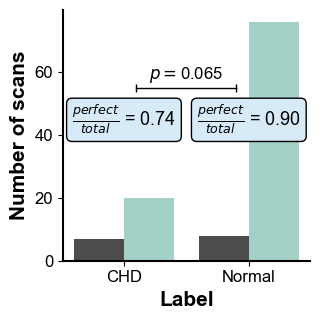

In [106]:
eval_label = pd.crosstab(label_df1["nnUnet"], label_df1["Label"]).stack().reset_index()
eval_label.columns = ["nnUnet", "Label", "Number"]

plt.figure(figsize=(3,3))
ax = sns.barplot(
    data=eval_label, x="Label", y="Number", hue="nnUnet", alpha=0.7,
    ci=None, 
    # palette=["#D98880", "#73C6B6", "#000000"]
    palette=["#000000", "#73C6B6"]
)
plt.ylabel("Number of scans", fontsize=15, weight='bold')
plt.xlabel("Label", fontsize=15, weight='bold')

plt.text(0,50,
         r'$\frac{perfect}{total}$'+ ' = {:.2f}'.format(
             eval_label[(eval_label["Label"]=="CHD") & (eval_label["nnUnet"]=="perfect")]["Number"].sum()/
             eval_label[eval_label["Label"]=="CHD"]["Number"].sum()),
         fontsize=13,
         ha="center", va="top",
         bbox=dict(boxstyle="round,pad=0.3", fc="#D6EAF8"));

plt.text(1,50,
         r'$\frac{perfect}{total}$'+ ' = {:.2f}'.format(
             eval_label[(eval_label["Label"]=="Normal") & (eval_label["nnUnet"]=="perfect")]["Number"].sum()/
             eval_label[eval_label["Label"]=="Normal"]["Number"].sum()),
         fontsize=13,
         ha="center", va="top",
         bbox=dict(boxstyle="round,pad=0.3", fc="#D6EAF8"))

plt.plot([0.1,0.9], [55, 55], linewidth=1, c="k", marker="|")
tb = pd.crosstab(label_df1["nnUnet"], label_df1["Label"])
plt.text(0.5, 59,
         r'$p=$' + '{:.3f} '.format(
            #  stats.ttest_ind(vals[0], vals[1]).pvalue
             chi2_contingency(tb)[1]
         ),
         ha="center", va="center",
         fontsize=12
        );
ax.legend_.remove()
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
today = datetime.now().strftime('%Y%m%d')
plt.savefig(os.path.join(SAVEDIR, f'labels_{today}.svg'), bbox_inches='tight', dpi=1000)

## Visualization

### Figure 3a

In [26]:
def vis_seg(im, 
            pred,
            i, 
            mask, 
            direction="axial", 
            figsize=(15,5), 
            alpha=0.5, 
            scalebar=None,
            save=None):
    fig = plt.figure(figsize=figsize)
    if direction == "axial":
        im = im[i,:,:].copy()
        pred = pred[i,:,:].copy()
        if mask is not None:
            mask = mask[i,:,:]
    elif direction == "coronal":
        im = np.flip(im[:,i,:].copy())
        pred = np.flip(pred[:,i,:].copy())
        if mask is not None:
            mask = np.flip(mask[:,i,:].copy())
    elif direction=="sagital":
        im = im[:,:,i].copy()
        pred = pred[:,:,i].copy()
        if mask is not None:
            mask = mask[:,:,i].copy()
    else:
        raise "Invalid direction"
        
    axes = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(2,2),
                    axes_pad=0.3,
                    share_all=True)
    n_ims = 4
    
    mask[mask != 0] = 1
    pred[pred != 0] = 2
    merge = pred + mask
    
    vmin = merge.min()
    vmax = merge.max()
    
    # Original image
    axes[0].imshow(im, cmap="gray")
    axes[0].set_title("original image", fontsize=20)
    
    # Manual segmentation
    axes[1].imshow(im, cmap="gray")
    axes[1].imshow(np.ma.masked_where(mask==0, mask), cmap="jet", vmin=vmin, vmax=vmax, alpha=alpha)
    axes[1].set_title("manual segmentation", fontsize=20)
    
    # Automatic segmentation
    axes[2].imshow(im, cmap="gray")
    axes[2].imshow(np.ma.masked_where(pred==0, pred), cmap="jet", vmin=vmin, vmax=vmax, alpha=alpha)
    axes[2].set_title("automatic segmentation", fontsize=20)
    
    # Overlay
    axes[3].imshow(im, cmap="gray")
    axes[3].imshow(np.ma.masked_where(merge==0, merge), cmap="jet", vmin=vmin, vmax=vmax, alpha=alpha)
    axes[3].set_title("overlay", fontsize=20)
    label_names = ["manual", "prediction", "overlap"]
    colormap = dict(zip([0,1,2], ["#00d4ff","#ffe500","#7f0000"]))
    plt_handlers = []
    plt_titles = []
    for label_value, label_name in enumerate(label_names):
        fc = colormap[label_value]
        p = plt.Rectangle((0, 0), 1, 1, fc=fc)
        plt_handlers.append(p)
        plt_titles.append('{name}'
                            .format(name=label_name))
    axes[3].legend(plt_handlers, plt_titles, loc="upper left", framealpha=.5, fontsize=18)
    
    
        
    for i in range(n_ims):
        axes[i].axis("off")
    
    if scalebar is not None:
        x = 10
        y = 50
        text_y = 10
        axes[0].plot([x, x+200],
                     [y, y],
                     color="w",
                     marker="|",
                     markersize=15, 
                     markeredgewidth=5,
                     linewidth=5
                     )
        axes[0].text(x+100,
                text_y,
                "4mm",
                color="w",
                ha="center", va="top",
                weight="bold",
                fontsize=18)
        
    if save is not None:
        plt.savefig(save, bbox_inches="tight", pad_inches=0.2)

In [4]:
imname = "NH_291m"

img = sitk.ReadImage(f"{DATADIR}/processed/Imagine/images/{imname}_0000")
img = sitk.GetArrayFromImage(img)

gt = sitk.ReadImage(f"{DATADIR}/processed/Imagine/heart-masks/{imname}")
gt = sitk.GetArrayFromImage(gt)

mask = tifffile.imread(f"{OUTDIR}/POSTPROCESSED/{imname}.tif")

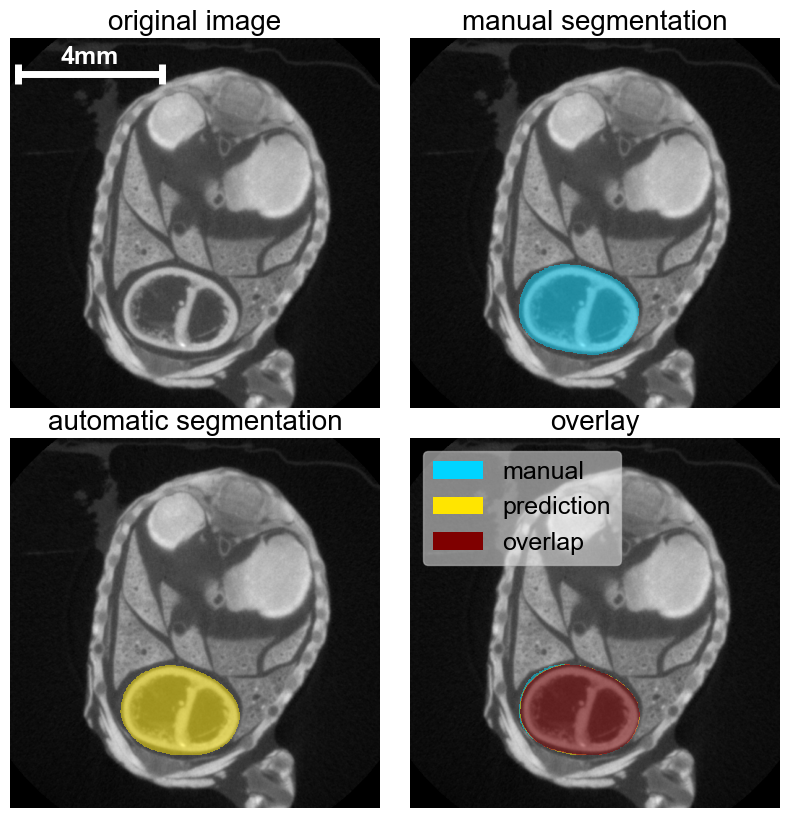

In [28]:
i = 270
today = datetime.now().strftime('%Y%m%d')
vis_seg(im=img,
       pred=(mask != 0)*1,
       i = i,
       mask=(gt != 0)*1,
       figsize=(10,10),
       alpha=0.5,
       scalebar=True,
       save=f"{SAVEDIR}/segment_overlay_Imagine_{imname}_axial_slice{i}_{today}.svg"
       )

### Supplementary Figure 01

#### 2D

In [147]:
eval_df["nnUNet segmentation"].value_counts()

nnUNet segmentation
OK perfect                122
missing tissue             15
extra tissue segmented      2
Name: count, dtype: int64

In [148]:

SAVEDIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/PAPER/FIGURES/Sup01/Components"
os.makedirs(SAVEDIR, exist_ok=True)
eval_df = pd.read_csv(f"{OUTDIR}/seg-validation.csv", sep=";")
seg_metrics = pd.read_csv(f"{OUTDIR}/metrics_postprocessed_ensemble.csv")

def nii2arr(path):
    img = sitk.ReadImage(path)
    
    return sitk.GetArrayFromImage(img)
    

def choose_worst_slices(mask, seg, n=2):
    (min_z1, max_z1), (_, _), (_, _) = get_bbx(mask)
    (min_z2, max_z2), (_, _), (_, _) = get_bbx(seg)
    min_z = max(min_z1, min_z2)
    max_z = min(max_z1, max_z2)
    
    dices = []
    for i in range(min_z, max_z):
        dices.append(calc_dsc(seg[i,:,:], mask[i,:,:]))
        
        
    sorted_idx = sorted(range(len(dices)), key=lambda k: dices[k])
    sorted_idx = [min_z + i for i in sorted_idx]
    
    return sorted_idx[:n]


def read_segmentation(heartls, imdir, maskdir, preddir):
    results = {"img": [], "mask": [], "pred": []}
    for heart in heartls:
        results["img"].append(nii2arr(f"{imdir}/{heart}_0000"))
        results["mask"].append(nii2arr(f"{maskdir}/{heart}"))
        results["pred"].append(tifffile.imread(f"{preddir}/{heart}.tif"))
        
    return results


def gen_3dsegment_lists(seg_imgs):
    ims = []
    masks = []
    for i in range(len(seg_imgs['img'])):
        ims += [seg_imgs['img'][i] for _ in range(4)]
        mask = seg_imgs['mask'][i]
        mask[mask > 0] = 1
        pred = seg_imgs['pred'][i]
        pred[pred > 0] = 2
        masks += [None, mask, pred, mask + pred]

    return ims, masks

def gen_2dsegment_lists(seg_imgs, nslices=2, **kwargs):
    import random
    random.seed(kwargs.get('seed', 42))
    
    pad = kwargs.get('pad', 0)
    ims = []
    masks = []
    for im, mask, pred in zip(seg_imgs['img'], seg_imgs['mask'], seg_imgs['pred']):
        mask[mask != 0] = 1
        pred[pred != 0] = 2
        
        indices = kwargs.get('indices', None)
        if indices is None:
            heart_pos = np.where(mask != 0)
            min_z, max_z = heart_pos[0].min(), heart_pos[0].max()
            indices = random.choices(range(min_z+pad, max_z-pad), k=nslices)
            
        for idx in indices:
            ims += [im[idx,:,:] for _ in range(4)]
            masks += [None, mask[idx,:,:], pred[idx,:,:],
                      mask[idx,:,:] + pred[idx,:,:]]
            print("Slice {}: {}".format(idx, calc_dsc(pred[idx,:,:], mask[idx,:,:])))

    return ims, masks

In [152]:
heartls = seg_metrics.sort_values("dsc").reset_index(drop=True)["heart_name"].tolist()[:3]
print(heartls)


['NH_1048', 'NH_294m', 'NH_224C']


In [142]:
seg_metrics.sort_values("dsc").reset_index(drop=True)

,heart_name,dsc,precision,recall,accuracy
0,NH_1048,0.957179,0.959225,0.955142,0.999371
1,NH_294m,0.957717,0.984908,0.931987,0.998515
2,NH_224C,0.958776,0.958977,0.958575,0.998762
3,NH_374,0.960667,0.958103,0.963244,0.999355
4,NH_342m,0.962745,0.958549,0.966979,0.998997
5,NH_256c,0.963647,0.960269,0.967048,0.999123
6,NH_233C,0.965973,0.975558,0.956574,0.998619
7,NH_315m,0.966552,0.981520,0.952033,0.998735
8,NH_1020,0.969566,0.960181,0.979136,0.999434
9,NH_314m,0.969920,0.979973,0.960071,0.998871


['NH_1048']
Slice 272: 0.8361204013377926
Slice 273: 0.8285504047093452
DSC: 0.9571791120290468


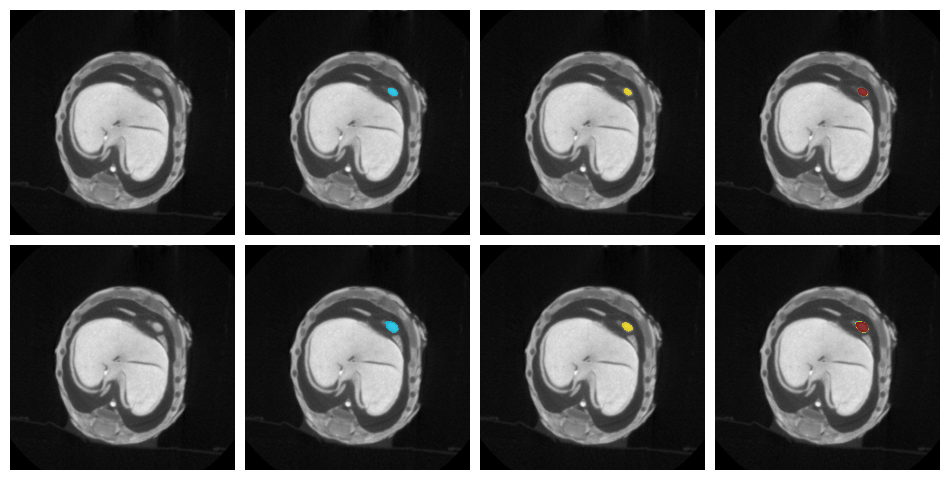

In [137]:
hearts = [heartls[0]]
print(hearts)
seg_imgs = read_segmentation(heartls=hearts, 
                             imdir=f"{DATADIR}/processed/Imagine/images", 
                             maskdir=MASKDIR,
                             preddir=f"{OUTDIR}/POSTPROCESSED")

seg_metrics.sort_values("dsc").reset_index(drop=True)
indices = sorted(choose_worst_slices(seg_imgs['mask'][0], seg_imgs['pred'][0], n=2))
ims, masks = gen_2dsegment_lists(seg_imgs, indices=indices)
fig = plot_gallery(ims, masks, alpha=0.7)
print("DSC: {}".format(calc_dsc(seg_imgs['pred'][0], seg_imgs['mask'][0])))
fig.savefig("{}/segment_overlay2d_{}_{}_{}.svg".format(SAVEDIR, hearts[0], *indices),
            bbox_inches="tight", dpi=1000)

['NH_294m']
Slice 415: 0.3409464644619039
Slice 416: 0.11476213830308975
DSC: 0.9577169369926083


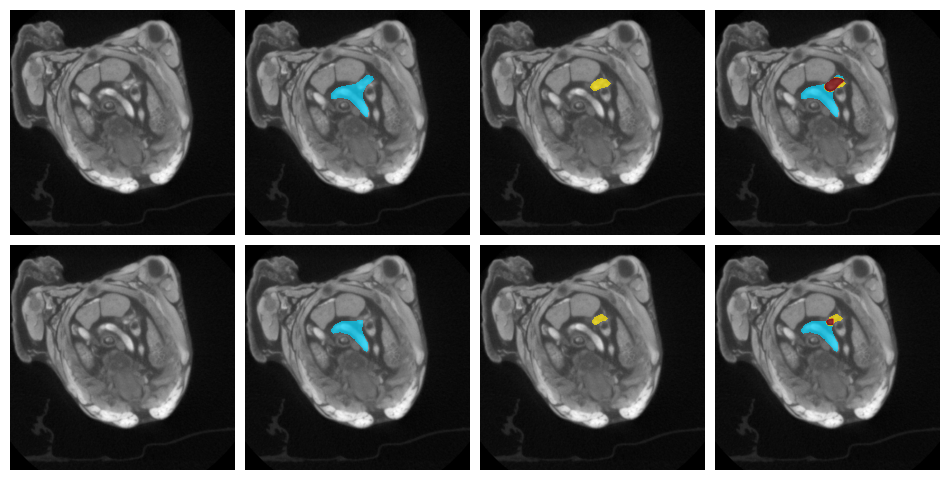

In [138]:
hearts = [heartls[1]]
print(hearts)
seg_imgs = read_segmentation(heartls=hearts, 
                             imdir=f"{DATADIR}/processed/Imagine/images", 
                             maskdir=MASKDIR,
                             preddir=f"{OUTDIR}/POSTPROCESSED")

seg_metrics.sort_values("dsc").reset_index(drop=True)
indices = sorted(choose_worst_slices(seg_imgs['mask'][0], seg_imgs['pred'][0], n=2))
ims, masks = gen_2dsegment_lists(seg_imgs, indices=indices)
fig = plot_gallery(ims, masks, alpha=0.7)
print("DSC: {}".format(calc_dsc(seg_imgs['pred'][0], seg_imgs['mask'][0])))
fig.savefig("{}/segment_overlay2d_{}_{}_{}.svg".format(SAVEDIR, hearts[0], *indices),
            bbox_inches="tight", dpi=1000)

['NH_224C']
Slice 151: 0.19581958195819582
Slice 309: 0.2122950819672131
DSC: 0.9587760683370609


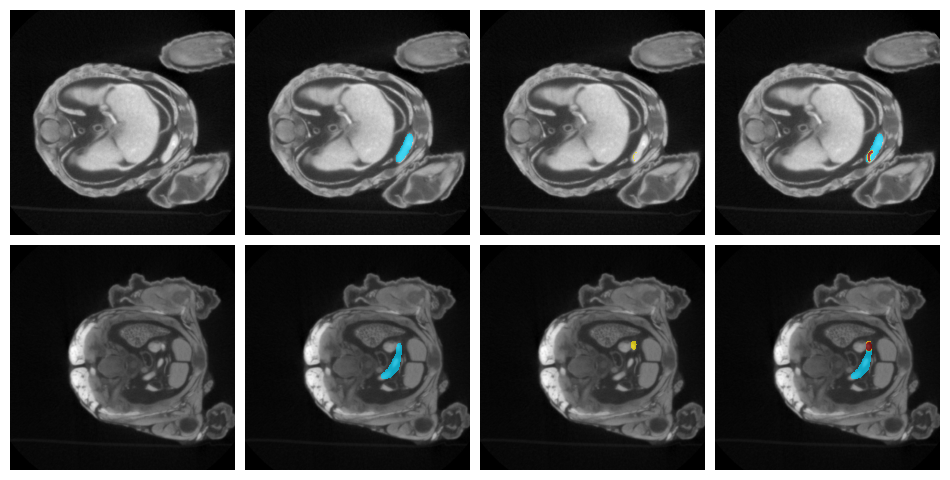

In [139]:
hearts = [heartls[2]]
print(hearts)
seg_imgs = read_segmentation(heartls=hearts, 
                             imdir=f"{DATADIR}/processed/Imagine/images", 
                             maskdir=MASKDIR,
                             preddir=f"{OUTDIR}/POSTPROCESSED")

seg_metrics.sort_values("dsc").reset_index(drop=True)
indices = sorted(choose_worst_slices(seg_imgs['mask'][0], seg_imgs['pred'][0], n=2))
ims, masks = gen_2dsegment_lists(seg_imgs, indices=indices)
fig = plot_gallery(ims, masks, alpha=0.7)
print("DSC: {}".format(calc_dsc(seg_imgs['pred'][0], seg_imgs['mask'][0])))
fig.savefig("{}/segment_overlay2d_{}_{}_{}.svg".format(SAVEDIR, hearts[0], *indices),
            bbox_inches="tight", dpi=1000)

['NH_256c']
Slice 394: 0.5231301340250757
Slice 395: 0.34692635423006696
DSC: 0.963646822363905


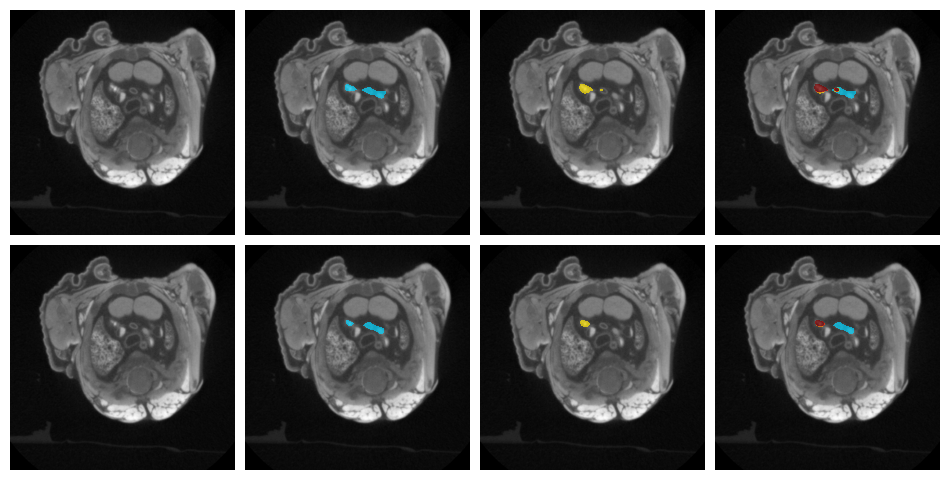

In [153]:
hearts = ['NH_256c']
print(hearts)
seg_imgs = read_segmentation(heartls=hearts, 
                             imdir=f"{DATADIR}/processed/Imagine/images", 
                             maskdir=MASKDIR,
                             preddir=f"{OUTDIR}/POSTPROCESSED")

seg_metrics.sort_values("dsc").reset_index(drop=True)
indices = sorted(choose_worst_slices(seg_imgs['mask'][0], seg_imgs['pred'][0], n=2))
ims, masks = gen_2dsegment_lists(seg_imgs, indices=indices)
fig = plot_gallery(ims, masks, alpha=0.7)
print("DSC: {}".format(calc_dsc(seg_imgs['pred'][0], seg_imgs['mask'][0])))
fig.savefig("{}/segment_overlay2d_{}_{}_{}.svg".format(SAVEDIR, hearts[0], *indices),
            bbox_inches="tight", dpi=1000)

#### 3D

See: [09_analyze.sh](../scripts/09_analyze.sh)

In [141]:
!mousechd viz3d_seg \
    -imdir "$HOME/DATA/INCEPTION_2020-CHD/Mice/DATA/CTs/processed/Imagine/images" \
    -maskdir "$HOME/DATA/INCEPTION_2020-CHD/Mice/DATA/CTs/processed/Imagine/heart-masks" \
    -preddir "$HOME/DATA/INCEPTION_2020-CHD/Mice/OUTPUTS/HeartSeg/Imagine" \
    -imname "NH_256c" \
    -savedir "$HOME/DATA/INCEPTION_2020-CHD/Mice/PAPER/FIGURES/Sup01/Components"



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

In [ ]:
!mousechd viz3d_seg \
    -imdir "$HOME/DATA/INCEPTION_2020-CHD/Mice/DATA/CTs/processed/Imagine/images" \
    -maskdir "$HOME/DATA/INCEPTION_2020-CHD/Mice/DATA/CTs/processed/Imagine/heart-masks" \
    -preddir "$HOME/DATA/INCEPTION_2020-CHD/Mice/OUTPUTS/HeartSeg/Imagine" \
    -imname "NH_1048" \
    -savedir "$HOME/DATA/INCEPTION_2020-CHD/Mice/PAPER/FIGURES/Sup01/Components"